[View in Colaboratory](https://colab.research.google.com/github/Tzeny/cifar10/blob/master/Cifar10.ipynb)

In [16]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 9.5 GB  | Proc size: 3.7 GB
GPU RAM Free: 503MB | Used: 10936MB | Util  96% | Total 11439MB


In [0]:
 !kill -9 -1

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

Using TensorFlow backend.


170500096/170498071 [==============================] - 14s 0us/step


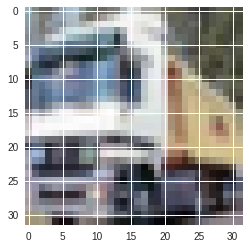

In [3]:
#gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

plt.imshow(x_train_gray[1], cmap='gray')
plt.imshow(x_train[1])

x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

i=0

In [0]:
import datetime

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

def build_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization, name='tower_%d_%dx%da'%(tower_nr, shape[0], shape[1]))(input_layer)
    tower = Conv2D(features_nr*2, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, name='tower_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(tower)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, 
                   name='tower_simple_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(input_layer)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_simple_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2):  
    tower_1 = build_tower(input_layer, features_nr, (3,3), module_nr, 
                          dropout, normalization, regularization, dropout_ratio)

    tower_2 = build_tower(input_layer, features_nr, (5,5), module_nr, 
                          dropout, normalization, regularization, dropout_ratio)

    #max pooling tower
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same', name='inception_%d_pool3x3a'%(module_nr))(input_layer)
    tower_3 = Conv2D(features_nr*2, (1,1), padding='same', activation='relu',
                    kernel_regularizer=regularization, name='inception_%d_pool3x3b'%(module_nr))(tower_3)
    if dropout:
        tower_3 = Dropout(dropout_ratio, name='inception_%d_pool3x3drop'%(module_nr))(tower_3)
    if normalization:
        tower_3 = BatchNormalization(name='inception_%d_pool3x3norm'%(module_nr))(tower_3)

    #concatenate and subsample towers
    output = concatenate([tower_1, tower_2, tower_3], axis = 3, name='inception_%d_concat'%(module_nr))

    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(output)
    
    return pooled

i=datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

!mkdir -p models
!mkdir -p cifar10-logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_loss', filepath='./models/cifar10-'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./cifar10-logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------model definition-------------------

use_norm = True
lrate = 0.001

input_img = Input(shape = (32, 32, 3), name='input')

#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
               # kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

#hopefully this will learn a good internal representation of the image channels
#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
                #kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

inception_1 = build_inception_module(input_img, 3, 1, True, use_norm)

inception_2 = build_inception_module(inception_1, 36, 2, True, use_norm)

inception_3 = build_inception_module(inception_2, 144, 3, True, use_norm)

#tower_3 = build_simple_tower(inception_2, 144, (3,3),  3, False, use_norm)
#tower_4 = build_simple_tower_subsample(tower_3, 144, (3,3), 4, False, use_norm)

tower_5 = build_simple_tower(inception_3, 288, (3,3),  5, False, use_norm)
tower_6 = build_simple_tower_subsample(tower_5, 288, (3,3), 6, False, use_norm)

#model top

flat = Flatten()(tower_6)

dense_5 = build_dense(flat, 128, 1, True, use_norm)

dense_6 = build_dense(dense_5, 64, 2, True, use_norm)

out = Dense(10, activation='softmax')(dense_6)

model = Model(inputs = input_img, outputs = out)

#-----------------------------------------------

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lrate),
              metrics=['accuracy'])

model.summary()

model_json = model.to_json()
with open("./models/cifar10-"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to" + "../models/cifar10-"+str(i)+".json")


In [11]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("Memory usage (GB):", get_model_memory_usage(128,model))

Memory usage (GB): 1.073


In [12]:
import tensorflow as tf

with tf.device('/gpu:0'):
  model.fit(x_train, y_train_cat, batch_size=128, epochs=100, validation_split=0.2,verbose=1,callbacks=callbacks)  # starts training

result = model.evaluate(x_test, y_test_cat)

print("Accuracy on test set: ",result[1]*100,"%")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 41s 1ms/step - loss: 1.7731 - acc: 0.9018 - val_loss: 0.4834 - val_acc: 0.9001

Epoch 00001: val_loss improved from inf to 0.48337, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 2/100
17408/40000 [============>.................] - ETA: 19s - loss: 0.3830 - acc: 0.9085

40000/40000 [==============================] - 36s 911us/step - loss: 0.3594 - acc: 0.9100 - val_loss: 0.3691 - val_acc: 0.9029

Epoch 00002: val_loss improved from 0.48337 to 0.36906, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 3/100
31872/40000 [======================>.......] - ETA: 6s - loss: 0.3176 - acc: 0.9141

40000/40000 [==============================] - 37s 913us/step - loss: 0.3165 - acc: 0.9144 - val_loss: 0.3406 - val_acc: 0.9071

Epoch 00003: val_loss improved from 0.36906 to 0.34059, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 4/100
35456/40000 [=========================>....] - ETA: 3s - loss: 0.3046 - acc: 0.9170

40000/40000 [==============================] - 36s 911us/step - loss: 0.3043 - acc: 0.9171 - val_loss: 0.3859 - val_acc: 0.8989

Epoch 00004: val_loss did not improve from 0.34059
Epoch 5/100
40000/40000 [==============================] - 37s 913us/step - loss: 0.2939 - acc: 0.9198 - val_loss: 0.3567 - val_acc: 0.9010

Epoch 00005: val_loss did not improve from 0.34059
Epoch 6/100
 2816/40000 [=>............................] - ETA: 31s - loss: 0.2917 - acc: 0.9219

40000/40000 [==============================] - 37s 914us/step - loss: 0.2874 - acc: 0.9218 - val_loss: 0.3253 - val_acc: 0.9153

Epoch 00006: val_loss improved from 0.34059 to 0.32533, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 7/100
28288/40000 [====================>.........] - ETA: 9s - loss: 0.2843 - acc: 0.9224 

40000/40000 [==============================] - 37s 914us/step - loss: 0.2839 - acc: 0.9223 - val_loss: 0.3854 - val_acc: 0.8937

Epoch 00007: val_loss did not improve from 0.32533
Epoch 8/100
40000/40000 [==============================] - 36s 911us/step - loss: 0.2788 - acc: 0.9237 - val_loss: 0.6566 - val_acc: 0.8351

Epoch 00008: val_loss did not improve from 0.32533
Epoch 9/100
 1536/40000 [>.............................] - ETA: 32s - loss: 0.2787 - acc: 0.9221

40000/40000 [==============================] - 36s 912us/step - loss: 0.2738 - acc: 0.9240 - val_loss: 0.2907 - val_acc: 0.9155

Epoch 00009: val_loss improved from 0.32533 to 0.29067, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 10/100
27904/40000 [===================>..........] - ETA: 10s - loss: 0.2690 - acc: 0.9250

40000/40000 [==============================] - 37s 915us/step - loss: 0.2698 - acc: 0.9248 - val_loss: 0.3317 - val_acc: 0.9106

Epoch 00010: val_loss did not improve from 0.29067
Epoch 11/100
40000/40000 [==============================] - 36s 912us/step - loss: 0.2646 - acc: 0.9265 - val_loss: 0.2994 - val_acc: 0.9153

Epoch 00011: val_loss did not improve from 0.29067
Epoch 12/100
 1408/40000 [>.............................] - ETA: 32s - loss: 0.2609 - acc: 0.9271

40000/40000 [==============================] - 36s 912us/step - loss: 0.2656 - acc: 0.9261 - val_loss: 0.3661 - val_acc: 0.9026

Epoch 00012: val_loss did not improve from 0.29067
Epoch 13/100
34432/40000 [========================>.....] - ETA: 4s - loss: 0.2578 - acc: 0.9275

40000/40000 [==============================] - 37s 913us/step - loss: 0.2581 - acc: 0.9273 - val_loss: 0.2919 - val_acc: 0.9191

Epoch 00013: val_loss did not improve from 0.29067
Epoch 14/100
40000/40000 [==============================] - 37s 913us/step - loss: 0.2572 - acc: 0.9271 - val_loss: 0.2954 - val_acc: 0.9161

Epoch 00014: val_loss did not improve from 0.29067
Epoch 15/100
 2432/40000 [>.............................] - ETA: 32s - loss: 0.2440 - acc: 0.9306

40000/40000 [==============================] - 36s 910us/step - loss: 0.2055 - acc: 0.9374 - val_loss: 0.2495 - val_acc: 0.9178

Epoch 00015: val_loss improved from 0.29067 to 0.24954, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 16/100
28160/40000 [====================>.........] - ETA: 10s - loss: 0.1865 - acc: 0.9417

40000/40000 [==============================] - 37s 913us/step - loss: 0.1858 - acc: 0.9419 - val_loss: 0.2406 - val_acc: 0.9239

Epoch 00016: val_loss improved from 0.24954 to 0.24056, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 17/100
34432/40000 [========================>.....] - ETA: 4s - loss: 0.1769 - acc: 0.9448

40000/40000 [==============================] - 37s 913us/step - loss: 0.1768 - acc: 0.9448 - val_loss: 0.2281 - val_acc: 0.9272

Epoch 00017: val_loss improved from 0.24056 to 0.22805, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 18/100
35968/40000 [=========================>....] - ETA: 3s - loss: 0.1718 - acc: 0.9463

40000/40000 [==============================] - 36s 910us/step - loss: 0.1715 - acc: 0.9464 - val_loss: 0.2128 - val_acc: 0.9308

Epoch 00018: val_loss improved from 0.22805 to 0.21284, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 19/100
36352/40000 [==========================>...] - ETA: 3s - loss: 0.1659 - acc: 0.9488

40000/40000 [==============================] - 36s 911us/step - loss: 0.1661 - acc: 0.9488 - val_loss: 0.2039 - val_acc: 0.9335

Epoch 00019: val_loss improved from 0.21284 to 0.20388, saving model to ./models/cifar10-06:43AM_July-07-2018.hdf5
Epoch 20/100
36480/40000 [==========================>...] - ETA: 3s - loss: 0.1623 - acc: 0.9504

40000/40000 [==============================] - 36s 912us/step - loss: 0.1623 - acc: 0.9504 - val_loss: 0.2263 - val_acc: 0.9257

Epoch 00020: val_loss did not improve from 0.20388
Epoch 21/100
40000/40000 [==============================] - 36s 910us/step - loss: 0.1588 - acc: 0.9521 - val_loss: 0.2170 - val_acc: 0.9292

Epoch 00021: val_loss did not improve from 0.20388
Epoch 22/100
 2944/40000 [=>............................] - ETA: 31s - loss: 0.1539 - acc: 0.9535

40000/40000 [==============================] - 36s 911us/step - loss: 0.1554 - acc: 0.9533 - val_loss: 0.2455 - val_acc: 0.9178

Epoch 00022: val_loss did not improve from 0.20388
Epoch 23/100
34944/40000 [=========================>....] - ETA: 4s - loss: 0.1527 - acc: 0.9546

40000/40000 [==============================] - 37s 913us/step - loss: 0.1527 - acc: 0.9544 - val_loss: 0.2301 - val_acc: 0.9268

Epoch 00023: val_loss did not improve from 0.20388
Epoch 24/100
40000/40000 [==============================] - 37s 914us/step - loss: 0.1500 - acc: 0.9559 - val_loss: 0.2649 - val_acc: 0.9157

Epoch 00024: val_loss did not improve from 0.20388
Epoch 25/100
 2688/40000 [=>............................] - ETA: 31s - loss: 0.1405 - acc: 0.9583

40000/40000 [==============================] - 37s 913us/step - loss: 0.1374 - acc: 0.9604 - val_loss: 0.2232 - val_acc: 0.9267

Epoch 00025: val_loss did not improve from 0.20388
Epoch 26/100
34816/40000 [=========================>....] - ETA: 4s - loss: 0.1322 - acc: 0.9622

40000/40000 [==============================] - 36s 910us/step - loss: 0.1317 - acc: 0.9624 - val_loss: 0.2388 - val_acc: 0.9204

Epoch 00026: val_loss did not improve from 0.20388
Epoch 27/100
40000/40000 [==============================] - 36s 912us/step - loss: 0.1288 - acc: 0.9637 - val_loss: 0.2327 - val_acc: 0.9233

Epoch 00027: val_loss did not improve from 0.20388
Epoch 28/100
 2560/40000 [>.............................] - ETA: 31s - loss: 0.1294 - acc: 0.9636

40000/40000 [==============================] - 37s 913us/step - loss: 0.1271 - acc: 0.9637 - val_loss: 0.2342 - val_acc: 0.9223

Epoch 00028: val_loss did not improve from 0.20388
Epoch 29/100
34816/40000 [=========================>....] - ETA: 4s - loss: 0.1247 - acc: 0.9647

40000/40000 [==============================] - 37s 913us/step - loss: 0.1250 - acc: 0.9647 - val_loss: 0.2379 - val_acc: 0.9208

Epoch 00029: val_loss did not improve from 0.20388
Epoch 00029: early stopping
10000/10000 [==============================] - 5s 498us/step
Accuracy on test set:  92.13599914550781 %


In [14]:
model.load_weights('./models/cifar10-06:43AM_July-07-2018.hdf5')

result = model.evaluate(x_test, y_test_cat)

print(result)

10000/10000 [==============================] - 6s 578us/step
[0.20430024523735046, 0.9331499870300293]
